# Linear Algebra and Machine Learning Practice (Day 3)

## 목차 (Table of Contents)

준비 과정
- [라이브러리 설치 및 불러오기](#준비하기-라이브러리-설치-및-불러오기)
- [MNIST 데이터셋 불러오기](#MNIST-데이터셋-불러오기)

실습 (Practice)
1.  [Cholesky 분해 (Cholesky Decomposition)](#1-cholesky-분해-cholesky-decomposition)
2.  [고유값 분해 (Eigendecomposition)](#2-고유값-분해-eigendecomposition)
3.  [특이값 분해 (Singular Value Decomposition, SVD)](#3-특이값-분해-singular-value-decomposition-svd)
4.  [주성분 분석 (Principal Component Analysis, PCA)](#4-주성분-분석-principal-component-analysis-pca)

## 준비하기: 라이브러리 설치 및 불러오기

In [154]:
# 라이브러리 설치
import subprocess
import sys

def install_if_not_exists(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# 모든 실습에 필요한 라이브러리 목록
required_packages = ["numpy", "matplotlib", "scipy", "scikit-learn"]
for package in required_packages:
    install_if_not_exists(package)


# 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.datasets import fetch_openml

# 전체 실습의 재현성을 위해 랜덤 시드를 고정합니다.
np.random.seed(0)

## MNIST 데이터셋 불러오기
scikit-learn의 fetch_openml을 사용하여 MNIST 손글씨 숫자 데이터셋을 불러옵니다.
데이터는 784개의 픽셀(28x28)로 구성된 이미지이며, 0~255 값을 갖습니다.
실습에서 사용할 수 있도록 255로 나누어 정규화합니다.

In [155]:
print("MNIST 데이터셋을 불러오는 중... (몇 분 정도 소요될 수 있습니다)")
try:
    # as_frame=False : numpy array로 받기
    # parser='auto' : 최신 scikit-learn에서 권장하는 파서
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    
    X_mnist_data = mnist.data / 255.0  # 정규화
    y_mnist_data = mnist.target.astype(int)
    
    print("MNIST 데이터셋 로드 완료.")
    print(f"데이터 형태: {X_mnist_data.shape}")
    print(f"레이블 형태: {y_mnist_data.shape}")
except Exception as e:
    print(f"데이터셋 로드 중 오류 발생: {e}")
    print("인터넷 연결을 확인하거나, 잠시 후 다시 시도해주세요.")
    X_mnist_data, y_mnist_data = None, None

MNIST 데이터셋을 불러오는 중... (몇 분 정도 소요될 수 있습니다)
MNIST 데이터셋 로드 완료.
데이터 형태: (70000, 784)
레이블 형태: (70000,)


## 1. Cholesky 분해 (Cholesky Decomposition)
  
Cholesky 분해는 행렬 A가 대칭(Symmetric)이면서 양의 정부호(Positive Definite)라는 특별한 조건을 만족할 때 사용할 수 있는 효율적인 행렬 분해 방법입니다.

행렬 A를 아래와 같이 하삼각행렬(Lower-triangular matrix) L과 그 전치 행렬 L<sup>T</sup>의 곱으로 분해합니다.

$$
A = LL^T
$$

$$
\begin{bmatrix}
a_{11} & \cdots & a_{1n} \\
\vdots & \ddots & \vdots \\
a_{n1} & \cdots & a_{nn}
\end{bmatrix}
=
\begin{bmatrix}
l_{11} & 0 & \cdots & 0 \\
l_{21} & l_{22} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
l_{n1} & l_{n2} & \cdots & l_{nn}
\end{bmatrix}
\begin{bmatrix}
l_{11} & l_{21} & \cdots & l_{n1} \\
0 & l_{22} & \cdots & l_{n2} \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & l_{nn}
\end{bmatrix}
$$

Cholesky 분해는 선형 시스템 Ax=b를 매우 효율적으로 푸는 데 사용됩니다. A를 LL<sup>T</sup>로 대체하면, 복잡한 문제가 다음과 같이 두 개의 간단한 삼각 시스템 문제로 나뉩니다.

$$
\begin{aligned}
Ax &= b \\
(LL^T)x &= b \\
L(L^Tx) &= b
\end{aligned}
$$

여기서 L<sup>T</sup>x를 y로 치환하면, 아래의 두 단계로 해 x를 구할 수 있습니다.

1.  전방 대입법 (Forward Substitution): Ly = b를 풀어 중간 해 y를 구합니다.
2.  후방 대입법 (Backward Substitution): L^T x = y를 풀어 최종 해 x를 구합니다.

이 방식은 역행렬 $A^{-1}$을 직접 계산하는 것보다 수치적으로 훨씬 안정적이고 계산 비용이 저렴합니다.

### 1.1. 실습 데이터 준비 및 검증

일반적인 선형 시스템 문제에서는 행렬 A와 벡터 b가 주어지고, 미지의 해 x를 구하는 것이 목표입니다.

하지만 이 실습에서는 우리가 사용할 Cholesky 분해 방법이 올바르게 작동하는지 검증하는 것까지 목표로 합니다. 따라서 과정을 역으로 진행합니다.
1.  먼저, 우리가 찾고자 하는 정답 x를 임의로 정의합니다.
2.  그 다음, 이 x와 주어진 A를 사용하여 Ax = b를 만족하는 벡터 b를 계산합니다.

이렇게 A와 b가 준비되면, A와 b가 주어졌을 때 미지의 x를 구하라는 형태의 선형 시스템 문제가 완성됩니다. 이어지는 단계에서는 Cholesky 분해를 이용해 이 문제의 해를 구하고, 그 결과가 우리가 미리 설정해 둔 정답 x와 일치하는지 비교하여 전체 풀이 과정의 정확성을 검증할 것입니다.

또한, 행렬 A가 Cholesky 분해의 필수 조건(대칭, 양의 정부호)을 만족하는지도 함께 검증합니다.

In [156]:
# 실습: 아래 행렬 A의 값을 직접 바꿔보며, 검증 결과가 어떻게 변하는지 확인해보세요.
A_cholesky = np.array([
    [4., 2., 0.],
    [2., 5., 2.],
    [0., 2., 5.]
])
print("행렬 A:\n", A_cholesky)
print("-" * 30)

# 대칭 행렬 검증
is_symmetric = np.allclose(A_cholesky, A_cholesky.T)
print(f"A는 대칭 행렬인가? -> {is_symmetric}")

# 양의 정부호 행렬 검증
if is_symmetric:
    eigenvalues = np.linalg.eigvalsh(A_cholesky)
    is_positive_definite = np.all(eigenvalues > 0)
    print(f"A는 양의 정부호 행렬인가? -> {is_positive_definite}")
    if not is_positive_definite:
        print(f"   (고유값: {np.round(eigenvalues, 2)})")
else:
    print("A가 대칭이 아니므로, 양의 정부호 여부를 판단하지 않습니다.")
    is_positive_definite = False

cholesky_possible = is_symmetric and is_positive_definite
if not cholesky_possible:
    print("\n>> 경고: 행렬 A가 Cholesky 분해의 조건을 만족하지 않습니다.")

print("-" * 30)

# 실제 해 x를 정의하고 b를 계산
x_solution = np.array([1., 2., 3.])
b_cholesky = A_cholesky @ x_solution

print("우리가 찾으려는 실제 해 x:\n", x_solution)
print("\n계산된 벡터 b = Ax:\n", b_cholesky)

행렬 A:
 [[4. 2. 0.]
 [2. 5. 2.]
 [0. 2. 5.]]
------------------------------
A는 대칭 행렬인가? -> True
A는 양의 정부호 행렬인가? -> True
------------------------------
우리가 찾으려는 실제 해 x:
 [1. 2. 3.]

계산된 벡터 b = Ax:
 [ 8. 18. 19.]


### 1.2. Cholesky 분해 (A = LL<sup>T</sup>)
이제 조건이 맞는 행렬 A를 하삼각행렬 L로 분해합니다.

In [157]:
# scipy.linalg.cholesky는 기본적으로 하삼각행렬 L을 반환합니다.
L = None 
if cholesky_possible:
    L = scipy.linalg.cholesky(A_cholesky, lower=True)
    print("Cholesky 분해 결과, 하삼각행렬 L:\n", np.round(L, 2))
    
    # 분해 검증
    print("\n분해 검증 (L @ L.T):\n", L @ L.T)
    print("A와 LL.T가 일치하는가?", np.allclose(A_cholesky, L @ L.T))
else:
    print("행렬 A가 Cholesky 분해 조건을 만족하지 않아 분해를 시도하지 않습니다.")

Cholesky 분해 결과, 하삼각행렬 L:
 [[2. 0. 0.]
 [1. 2. 0.]
 [0. 1. 2.]]

분해 검증 (L @ L.T):
 [[4. 2. 0.]
 [2. 5. 2.]
 [0. 2. 5.]]
A와 LL.T가 일치하는가? True


### 1.3. 선형 시스템 풀이 (전방/후방 대입법)
분해된 L 행렬을 이용해, 선형 시스템을 두 단계로 나누어 풉니다.
1.  전방 대입법 (Ly = b): 중간 해 y를 구합니다.
2.  후방 대입법 (L^T x = y): 최종 해 x를 구합니다.

In [158]:
if L is not None:
    # 1. Ly = b 풀이 (전방 대입법)
    y = scipy.linalg.solve_triangular(L, b_cholesky, lower=True)
    print("1. 중간 해 y:\n", np.round(y, 2))

    # 2. L.T @ x = y 풀이 (후방 대입법)
    x_cholesky = scipy.linalg.solve_triangular(L.T, y, lower=False)
    print("\n2. 최종 해 x:\n", np.round(x_cholesky, 2))
else:
    print("L이 생성되지 않아 풀이 과정을 건너뜁니다.")

1. 중간 해 y:
 [4. 7. 6.]

2. 최종 해 x:
 [1. 2. 3.]


### 1.4. 최종 검증
Cholesky 분해를 통해 구한 해가 우리가 미리 정의했던 실제 해 x와 일치하는지, 그리고 np.linalg.solve를 이용해 직접 구한 해와도 일치하는지 확인하여 계산이 정확했는지 검증합니다.

In [159]:
if L is not None:
    # 우리가 아는 실제 해와 비교
    print("Cholesky 해와 실제 해 x가 일치합니까?", np.allclose(x_cholesky, x_solution))

    # np.linalg.solve와 결과 비교
    x_direct = np.linalg.solve(A_cholesky, b_cholesky)
    print("np.linalg.solve 해와 실제 해 x가 일치합니까?", np.allclose(x_direct, x_solution))
    
    print("\nCholesky 해:\n", np.round(x_cholesky, 2))
    print("np.linalg.solve 해:\n", np.round(x_direct, 2))
    print("실제 해 x:\n", x_solution)

else:
    print("L이 생성되지 않아 최종 검증을 건너뜁니다.")

Cholesky 해와 실제 해 x가 일치합니까? True
np.linalg.solve 해와 실제 해 x가 일치합니까? True

Cholesky 해:
 [1. 2. 3.]
np.linalg.solve 해:
 [1. 2. 3.]
실제 해 x:
 [1. 2. 3.]


## 2. 고유값 분해 (Eigendecomposition)

고유값 분해(Eigendecomposition)는 특정 조건을 만족하는 정방 행렬(square matrix) A를 세 행렬의 곱으로 분해하는 방법입니다.

$$A = PDP^{-1}$$

* A: n x n 크기의 정방 행렬(square matrix)입니다.
* P: A의 고유벡터(eigenvector)를 열(column)로 갖는 행렬입니다.
* D: A의 고유값(eigenvalue)을 대각 원소로 갖는 대각 행렬(diagonal matrix)입니다.
* P⁻¹: P의 역행렬(inverse matrix)입니다.

이 분해는 행렬 A가 n개의 선형 독립(linearly independent)인 고유벡터를 가질 때, 즉 대각화(diagonalization)가 가능할 때 성립합니다.

$$
A =
\begin{bmatrix}
\vdots & \vdots & & \vdots \\
v_1 & v_2 & \cdots & v_n \\
\vdots & \vdots & & \vdots
\end{bmatrix}
\begin{bmatrix}
\lambda_1 & 0 & \cdots & 0 \\
0 & \lambda_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \lambda_n
\end{bmatrix}
\begin{bmatrix}
\vdots & \vdots & & \vdots \\
w_1 & w_2 & \cdots & w_n \\
\vdots & \vdots & & \vdots
\end{bmatrix}
$$
위 식에서 첫 번째 행렬은 고유벡터(eigenvector) 행렬 P, 두 번째는 고유값(eigenvalue) 대각 행렬 D, 세 번째는 P의 역행렬(inverse matrix) P⁻¹을 나타냅니다.

### 기하학적 의미: 복잡한 변환을 간단한 단계로 분해하기

고유값 분해는 복잡한 행렬 변환 $A$를 세 단계의 간단한 변환으로 나누어 이해할 수 있게 해줍니다. 벡터 $x$에 행렬 $A$를 곱하는 변환 $Ax$는 $PDP^{-1}x$와 같으며, 다음과 같은 순서로 해석할 수 있습니다.

1.  좌표계 변환 ($P^{-1}$ 적용):
    첫 단계는 벡터 $x$에 고유벡터 행렬의 역행렬 $P^{-1}$을 곱하는 것입니다. 이 연산은 벡터 $x$를 기존의 표준 좌표계에서 고유벡터들이 축을 이루는 새로운 좌표계로 변환합니다.

2.  크기 조절 ($D$ 적용):
    다음으로, 변환된 좌표값에 고유값 대각 행렬 $D$를 곱합니다. 고유벡터 좌표계에서는 복잡한 변환 $A$가, 각 축의 성분을 해당 고유값 $\lambda_i$만큼 곱해주는 간단한 크기 조절(scaling) 연산으로 대체됩니다.

3.  좌표계 복원 ($P$ 적용):
    마지막으로, 크기 조절이 완료된 벡터에 고유벡터 행렬 $P$를 곱합니다. 이 연산은 벡터를 다시 원래의 표준 좌표계로 되돌려 최종 변환 결과를 얻는 과정입니다.

### 2.1. 실습 데이터 준비 및 분해 조건 확인

고유값 분해를 적용하기 전, 주어진 행렬이 분해 가능한지 확인합니다. n x n 행렬의 고유벡터들이 n차원 공간의 기저(basis)를 이룰 수 있는지, 즉 고유벡터 행렬 P가 역행렬을 갖는지 판별합니다.

P의 행렬식(determinant)이 0이 아니면, P는 역행렬을 가지며 행렬 A는 고유값 분해가 가능합니다.

In [160]:
# 실습에 사용할 2x2 정방 행렬(square matrix) 정의
# 행렬의 값을 바꾸어 분해 가능 여부를 테스트해볼 수 있습니다.
# 예: A = np.array([[1, 1], [0, 1]]) -> 분해 불가능
A = np.array([
    [3, 1],
    [1, 3]
])
print("행렬 A:\n", A)
print("-" * 30)

# 분해 가능성 확인
try:
    eigenvalues, P = np.linalg.eig(A)
    
    # P의 행렬식(determinant)이 0에 가까운지 확인하여 분해 가능성 판별
    determinant_P = np.linalg.det(P)
    is_diagonalizable = not np.isclose(determinant_P, 0)
    
    print(f"고유벡터 행렬 P의 행렬식: {determinant_P:.2f}")
    print(f"행렬 A는 고유값 분해가 가능한가? -> {is_diagonalizable}")

except np.linalg.LinAlgError:
    is_diagonalizable = False
    print("행렬 A의 고유값 분해에 실패했습니다.")

행렬 A:
 [[3 1]
 [1 3]]
------------------------------
고유벡터 행렬 P의 행렬식: 1.00
행렬 A는 고유값 분해가 가능한가? -> True


### 2.2. 고유값 분해 (A = PDP⁻¹)

분해 조건을 만족하는 행렬 A를 P, D, P⁻¹ 행렬로 분해하고, 분해된 행렬들을 이용해 다시 A를 재구성해봅니다.

In [161]:
if is_diagonalizable:
    # D는 고유값(eigenvalue)을 대각 원소로 가지는 대각 행렬(diagonal matrix)
    D = np.diag(eigenvalues)
    
    # P의 역행렬(inverse matrix) 계산
    P_inv = np.linalg.inv(P)

    print("고유값 λ:\n", eigenvalues)
    print("\n고유벡터 행렬 P:\n", np.round(P, 2))
    print("\n대각행렬 D:\n", np.round(D, 2))
    print("\nP의 역행렬 P⁻¹:\n", np.round(P_inv, 2))
    
    # 분해 검증: A = PDP⁻¹
    A_reconstructed = P @ D @ P_inv
    print("\n재구성된 행렬 PDP⁻¹:\n", np.round(A_reconstructed, 2))
    print("\nA와 PDP⁻¹이 일치하는가?", np.allclose(A, A_reconstructed))
else:
    print("행렬 A가 분해 조건을 만족하지 않아 분해를 진행하지 않습니다.")

고유값 λ:
 [4. 2.]

고유벡터 행렬 P:
 [[ 0.71 -0.71]
 [ 0.71  0.71]]

대각행렬 D:
 [[4. 0.]
 [0. 2.]]

P의 역행렬 P⁻¹:
 [[ 0.71  0.71]
 [-0.71  0.71]]

재구성된 행렬 PDP⁻¹:
 [[3. 1.]
 [1. 3.]]

A와 PDP⁻¹이 일치하는가? True


### 2.3. 2D 변환을 통한 기하학적 의미 시각화

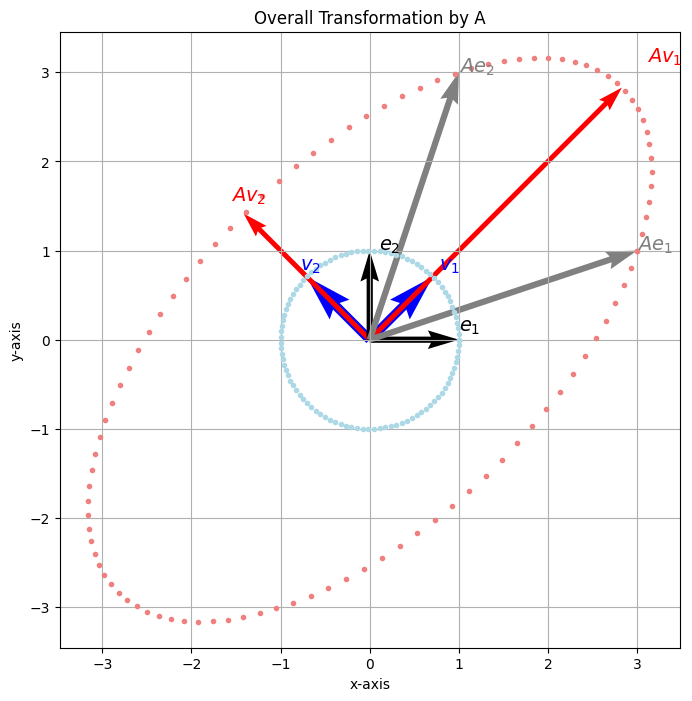

In [162]:
if is_diagonalizable:
    # 시각화를 위한 데이터 생성 (단위 원과 변환된 타원)
    t = np.linspace(0, 2 * np.pi, 100)
    circle_points = np.vstack([np.cos(t), np.sin(t)])
    transformed_points = A @ circle_points
    
    # 표준 기저 벡터(e1, e2)와 그 변환 결과(Ae1, Ae2)
    e1 = np.array([[1], [0]])
    e2 = np.array([[0], [1]])
    Ae1 = A @ e1
    Ae2 = A @ e2

    # 시각화 객체 생성
    plt.figure(figsize=(8, 8))
    ax1 = plt.gca()

    # 원본 점(단위 원)과 변환된 점(타원) 플로팅
    ax1.plot(circle_points[0, :], circle_points[1, :], 'o', c='lightblue', markersize=3)
    ax1.plot(transformed_points[0, :], transformed_points[1, :], 'o', c='lightcoral', markersize=3)

    # 고유벡터(v)와 그 변환 결과(Av = λv)를 화살표로 시각화
    for i in range(len(eigenvalues)):
        vec = np.real(P[:, i])
        transformed_vec = A @ vec
        ax1.quiver(0, 0, vec[0], vec[1], angles='xy', scale_units='xy', scale=1, color='blue', width=0.015)
        ax1.quiver(0, 0, transformed_vec[0], transformed_vec[1], angles='xy', scale_units='xy', scale=1, color='red', width=0.008)
        ax1.text(vec[0] * 1.1, vec[1] * 1.1, f'$v_{i+1}$', color='blue', size=14)
        ax1.text(transformed_vec[0] * 1.1, transformed_vec[1] * 1.1, f'$Av_{i+1}$', color='red', size=14)

    # 표준 기저 벡터와 그 변환 결과를 화살표로 시각화
    ax1.quiver(0, 0, e1[0], e1[1], angles='xy', scale_units='xy', scale=1, color='black', width=0.01)
    ax1.quiver(0, 0, e2[0], e2[1], angles='xy', scale_units='xy', scale=1, color='black', width=0.01)
    ax1.quiver(0, 0, Ae1[0], Ae1[1], angles='xy', scale_units='xy', scale=1, color='gray', width=0.01)
    ax1.quiver(0, 0, Ae2[0], Ae2[1], angles='xy', scale_units='xy', scale=1, color='gray', width=0.01)
    ax1.text(e1[0], e1[1] + 0.1, r'$e_1$', size=14)
    ax1.text(e2[0] + 0.1, e2[1], r'$e_2$', size=14)
    ax1.text(Ae1[0], Ae1[1], r'$Ae_1$', size=14, color='gray')
    ax1.text(Ae2[0], Ae2[1], r'$Ae_2$', size=14, color='gray')
    
    # 플롯 설정
    ax1.set_title('Overall Transformation by A')
    ax1.set_xlabel('x-axis')
    ax1.set_ylabel('y-axis')
    ax1.axis('equal')
    ax1.grid(True)
    plt.show()
else:
    print("행렬 A가 분해 조건을 만족하지 않아 시각화를 진행하지 않습니다.")

위 그림은 행렬 변환 A가 공간에 어떤 영향을 미치는지 한눈에 보여줍니다.
- 파란색 점(단위 원)이 행렬 A에 의해 빨간색 점(타원)으로 변환됩니다.
- 대부분의 벡터는 변환 시 방향이 바뀌지만(검은색 화살표 $e_1, e_2$가 회색 화살표 $Ae_1, Ae_2$로 변하는 것을 보세요), 파란색 벡터만은 방향이 바뀌지 않습니다.
- 변환 후의 빨간색 화살표는 원래 고유벡터에서 크기만 고유값($\lambda$) 배만큼 변한 것을 확인할 수 있습니다. ($Av = \lambda v$)
- 이 고유벡터들이 바로 선형 변환의 주축(principal axes)이 됩니다.

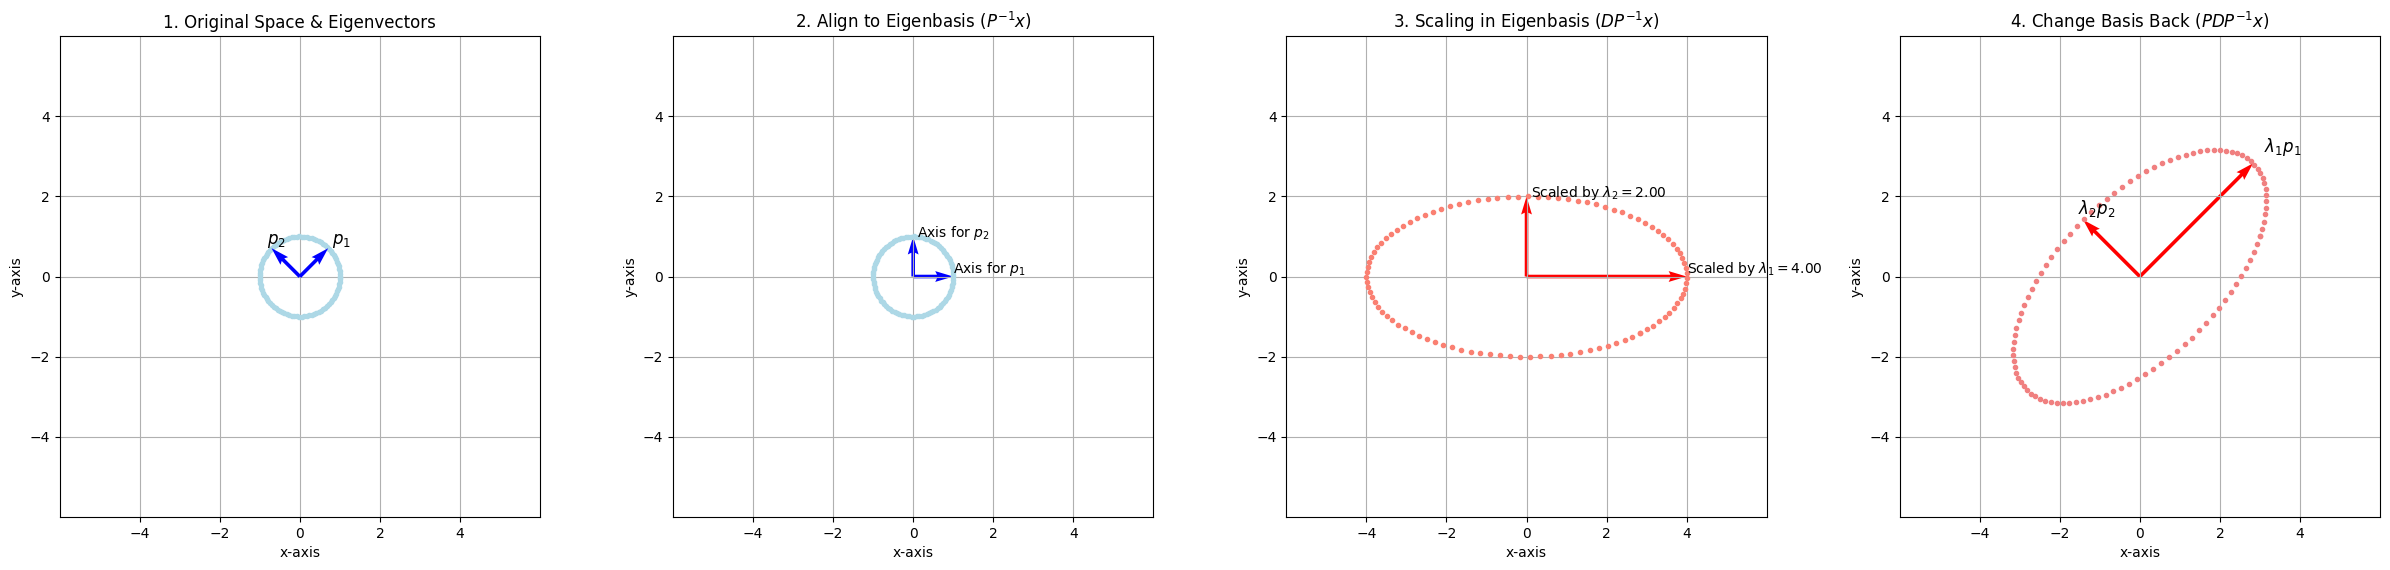

In [163]:
if is_diagonalizable:
    # 단계별 시각화를 위한 데이터 준비
    circle_points = np.vstack([np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100))])

    # 단계별 변환 계산 (P⁻¹ 적용 -> D 적용 -> P 적용)
    transformed_by_P_inv = P_inv @ circle_points
    scaled_by_D = D @ transformed_by_P_inv
    final_result = P @ scaled_by_D

    # 4개의 서브플롯 생성
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # 모든 플롯의 좌표축 범위를 통일하기 위한 계산
    all_points = np.hstack([circle_points, transformed_by_P_inv, scaled_by_D, final_result])
    x_min, x_max = all_points[:1].min(), all_points[:1].max()
    y_min, y_max = all_points[-1:].min(), all_points[-1:].max()
    padding = 1.5
    lim_x = (min(x_min, y_min) * padding, max(x_max, y_max) * padding)
    lim_y = lim_x

    # 1. 원본 공간과 고유벡터
    p1 = P[:, 0]
    p2 = P[:, 1]
    axesA0 = axes.flatten()[0]
    axesA0.set_title('1. Original Space & Eigenvectors')
    axesA0.plot(circle_points[:1].flatten(), circle_points[-1:].flatten(), 'o', c='lightblue', markersize=3)
    axesA0.quiver(0, 0, p1[:1].flatten(), p1[-1:].flatten(), angles='xy', scale_units='xy', scale=1, color='blue', zorder=5)
    axesA0.quiver(0, 0, p2[:1].flatten(), p2[-1:].flatten(), angles='xy', scale_units='xy', scale=1, color='blue', zorder=5)
    axesA0.text(p1[:1].flatten() * 1.15, p1[-1:].flatten() * 1.15, '$p_1$', fontsize=12)
    axesA0.text(p2[:1].flatten() * 1.15, p2[-1:].flatten() * 1.15, '$p_2$', fontsize=12)

    # 2. 기저 변환 (고유벡터 좌표계로 정렬)
    axesA1 = axes.flatten()[1]
    axesA1.set_title('2. Align to Eigenbasis ($P^{-1}x$)')
    axesA1.plot(transformed_by_P_inv[:1].flatten(), transformed_by_P_inv[-1:].flatten(), 'o', c='lightblue', markersize=3)
    axesA1.quiver(0, 0, 1, 0, angles='xy', scale_units='xy', scale=1, color='blue')
    axesA1.quiver(0, 0, 0, 1, angles='xy', scale_units='xy', scale=1, color='blue')
    axesA1.text(1, 0.1, 'Axis for $p_1$')
    axesA1.text(0.1, 1, 'Axis for $p_2$')

    # 3. 크기 조절 (스케일링)
    axesA2 = axes.flatten()[2]
    axesA2.set_title('3. Scaling in Eigenbasis ($D P^{-1}x$)')
    axesA2.plot(scaled_by_D[:1].flatten(), scaled_by_D[-1:].flatten(), 'o', c='salmon', markersize=3)
    axesA2.quiver(0, 0, eigenvalues[:1].flatten(), 0, angles='xy', scale_units='xy', scale=1, color='red')
    axesA2.quiver(0, 0, 0, eigenvalues[-1:].flatten(), angles='xy', scale_units='xy', scale=1, color='red')
    axesA2.text(eigenvalues[:1].flatten(), 0.1, f'Scaled by $\\lambda_1={eigenvalues[:1].flatten()[0]:.2f}$')
    axesA2.text(0.1, eigenvalues[-1:].flatten(), f'Scaled by $\\lambda_2={eigenvalues[-1:].flatten()[0]:.2f}$')

    # 4. 기저 원복 (원래 좌표계로 회전)
    axesA3 = axes.flatten()[3]
    axesA3.set_title('4. Change Basis Back ($P D P^{-1}x$)')
    axesA3.plot(final_result[:1].flatten(), final_result[-1:].flatten(), 'o', c='lightcoral', markersize=3)
    # 최종 변환된 고유벡터 방향을 표시
    final_p1 = A @ p1
    final_p2 = A @ p2
    axesA3.quiver(0, 0, final_p1[:1].flatten(), final_p1[-1:].flatten(), angles='xy', scale_units='xy', scale=1, color='red')
    axesA3.quiver(0, 0, final_p2[:1].flatten(), final_p2[-1:].flatten(), angles='xy', scale_units='xy', scale=1, color='red')
    axesA3.text(final_p1[:1].flatten() * 1.1, final_p1[-1:].flatten() * 1.1, '$\\lambda_1 p_1$', fontsize=12)
    axesA3.text(final_p2[:1].flatten() * 1.1, final_p2[-1:].flatten() * 1.1, '$\\lambda_2 p_2$', fontsize=12)

    # 모든 서브플롯에 공통 설정 적용
    for ax in axes.flatten():
        ax.grid(True)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(lim_x)
        ax.set_ylim(lim_y)
        ax.set_xlabel('x-axis')
        ax.set_ylabel('y-axis')

    plt.tight_layout()
    plt.show()
else:
    print("행렬 A가 분해 조건을 만족하지 않아 시각화를 진행하지 않습니다.")

### 고유값 분해의 시각적 이해

고유값 분해의 각 단계를 따라가 보면, 복잡해 보이는 변환 A가 사실은 세 가지 간단한 동작의 연속임을 알 수 있습니다. ($A = PDP^{-1}$)

1.  Original Space & Eigenvectors: 변환 전의 단위 원입니다. 여기에 행렬 A 변환의 핵심 방향인 고유벡터($p_1, p_2$)를 표시합니다. 이 두 벡터는 선형 변환 시 방향은 변하지 않고 크기만 변하는 특별한 축(axis) 역할을 합니다.
2.  Align to Eigenbasis ($P^{-1}$ 적용): 변환을 쉽게 파악하기 위해, 공간을 '회전'시켜 고유벡터 $p_1, p_2$가 표준 좌표축과 나란히 정렬되도록 만듭니다. 이로써 모든 변환이 축 방향으로 일어나도록 단순화됩니다. 이 '정렬' 역할을 $P^{-1}$ 행렬이 수행합니다.
3.  Scaling ($D$ 적용): 정렬된 축을 따라 각 방향으로 고유값($\lambda_1, \lambda_2$)만큼 벡터들을 늘리거나 줄입니다. 대각행렬 $D$는 이처럼 간단한 스케일링 변환을 담당합니다.
4.  Change Basis Back ($P$ 적용): 크기 조절이 끝난 벡터들을 다시 원래의 고유벡터 방향으로 '역회전'시켜 본래의 좌표계로 되돌려 놓습니다. 이 역할을 $P$ 행렬이 수행합니다. 그 결과는 행렬 A를 직접 적용한 변환 결과와 정확히 일치합니다.

결론적으로, 고유값 분해는 복잡한 선형 변환을 가장 다루기 쉬운 방향(고유벡터)이 좌표축과 일치하도록 공간을 정렬하고, 그곳에서 간단한 크기 조절(scaling)을 한 뒤, 다시 원래의 방향으로 되돌려 놓는 과정으로 해석할 수 있습니다.

## 3. 특이값 분해 (Singular Value Decomposition, SVD)

특이값 분해(SVD)는 임의의 m x n 행렬 A를 세 행렬의 곱으로 분해하는 방법입니다. 고유값 분해가 정방 행렬(square matrix)에만 적용 가능한 것과 달리, SVD는 모든 행렬에 적용할 수 있어 활용도가 매우 높습니다.

$$A = U\Sigma V^T$$

*   A: m x n 크기의 행렬입니다.
*   U: m x m 크기의 직교 행렬(orthogonal matrix)입니다. 열벡터는 좌측 특이벡터(left-singular vectors)라고 합니다. ($UU^T = I$)
*   \(\Sigma\): m x n 크기의 대각 행렬(diagonal matrix)입니다. 대각 원소는 특이값(singular values)이며, 0이 아닌 값들은 행렬 A의 양의 정부호(positive definite) 행렬인 $A^TA$의 고유값의 제곱근과 같습니다.
*   $V^T$: n x n 크기의 직교 행렬(orthogonal matrix) V의 전치 행렬입니다. V의 열벡터는 우측 특이벡터(right-singular vectors)라고 합니다. ($VV^T = I$)

$$
A =
\begin{bmatrix}
\vdots & \vdots & & \vdots \\
u_1 & u_2 & \cdots & u_m \\
\vdots & \vdots & & \vdots
\end{bmatrix}
\begin{bmatrix}
\sigma_1 & 0 & \cdots & 0 \\
0 & \sigma_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & 0 \\
\vdots & \vdots & & \vdots \\
0 & 0 & \cdots & 0
\end{bmatrix}
\begin{bmatrix}
\cdots & v_1 & \cdots \\
\cdots & v_2 & \cdots \\
& \vdots & \\
\cdots & v_n & \cdots
\end{bmatrix}
$$

### 기하학적 의미: 복잡한 변환을 회전, 크기 조절, 다시 회전으로 분해하기

SVD는 복잡한 행렬 변환 A를 세 단계의 간단한 변환으로 나누어 이해할 수 있게 해줍니다. 벡터 x에 행렬 A를 곱하는 변환 Ax는 $U\Sigma V^T x$와 같으며, 다음과 같은 순서로 해석할 수 있습니다.

1.  좌표계 회전 ($V^T$ 적용):
    첫 단계는 벡터 $x$에 $V^T$를 곱하는 것입니다. 이 연산은 입력 공간($R^n$)의 표준 기저를 우측 특이벡터($v_i$)를 축으로 하는 새로운 좌표계로 회전시킵니다.

2.  크기 조절 및 차원 변경 ($\Sigma$ 적용):
    다음으로, 변환된 좌표값에 대각 행렬 $\Sigma$를 곱합니다. 이 과정에서 각 축의 성분을 해당 특이값 $\sigma_i$만큼 곱해주는 크기 조절(scaling)이 일어나고, 동시에 차원이 m으로 변경됩니다. (예: $R^n \rightarrow R^m$)

3.  좌표계 회전 ($U$ 적용):
    마지막으로, 크기 조절이 완료된 벡터에 $U$를 곱합니다. 이 연산은 출력 공간($R^m$)에서 벡터를 좌측 특이벡터($u_i$)를 축으로 하는 좌표계로 다시 한번 회전시켜 최종 변환 결과를 얻습니다.

### 3.1. SVD 분해 및 결과 확인

SVD는 모든 행렬에 적용 가능합니다. 여기서는 R² 공간의 벡터를 R³ 공간으로 변환하는 3x2 행렬을 사용해 SVD를 실습하고, 분해된 행렬들을 확인하며 결과를 검증합니다.

In [164]:
# 실습에 사용할 3x2 행렬(matrix) 정의
A = np.array([
    [1, 2],
    [2, 1],
    [1, 1]
])
print("행렬 A:\n", A)
print("-" * 30)

# SVD 수행
# full_matrices=True로 하면 U는 m x m, Vh는 n x n 정방행렬이 반환됩니다.
# U: (m, m), s: (k,), Vh: (n, n) where k = min(m, n)
U, s, Vh = np.linalg.svd(A, full_matrices=True)

# Vh의 V는 Vh.T 로 얻을 수 있음.
V = Vh.T

# s는 특이값(singular values)의 1차원 배열이므로, m x n 크기의 대각 행렬 Sigma로 재구성해야 합니다.
Sigma = np.zeros(A.shape)
k = min(A.shape)
Sigma[:k, :k] = np.diag(s)

print("U 행렬 (좌측 특이벡터):\n", np.round(U, 2))
print("\n대각행렬 Σ (특이값):\n", np.round(Sigma, 2))
print("\nV 전치 행렬 Vᵀ (우측 특이벡터의 전치):\n", np.round(Vh, 2))

# 분해 검증: A = UΣVᵀ
A_reconstructed = U @ Sigma @ Vh
print("\n재구성된 행렬 UΣVᵀ:\n", np.round(A_reconstructed, 2))
print("\nA와 UΣVᵀ이 일치하는가?", np.allclose(A, A_reconstructed))

행렬 A:
 [[1 2]
 [2 1]
 [1 1]]
------------------------------
U 행렬 (좌측 특이벡터):
 [[-0.64  0.71 -0.3 ]
 [-0.64 -0.71 -0.3 ]
 [-0.43 -0.    0.9 ]]

대각행렬 Σ (특이값):
 [[3.32 0.  ]
 [0.   1.  ]
 [0.   0.  ]]

V 전치 행렬 Vᵀ (우측 특이벡터의 전치):
 [[-0.71 -0.71]
 [-0.71  0.71]]

재구성된 행렬 UΣVᵀ:
 [[1. 2.]
 [2. 1.]
 [1. 1.]]

A와 UΣVᵀ이 일치하는가? True


### 3.2. R² -> R³ 변환을 통한 기하학적 의미 시각화

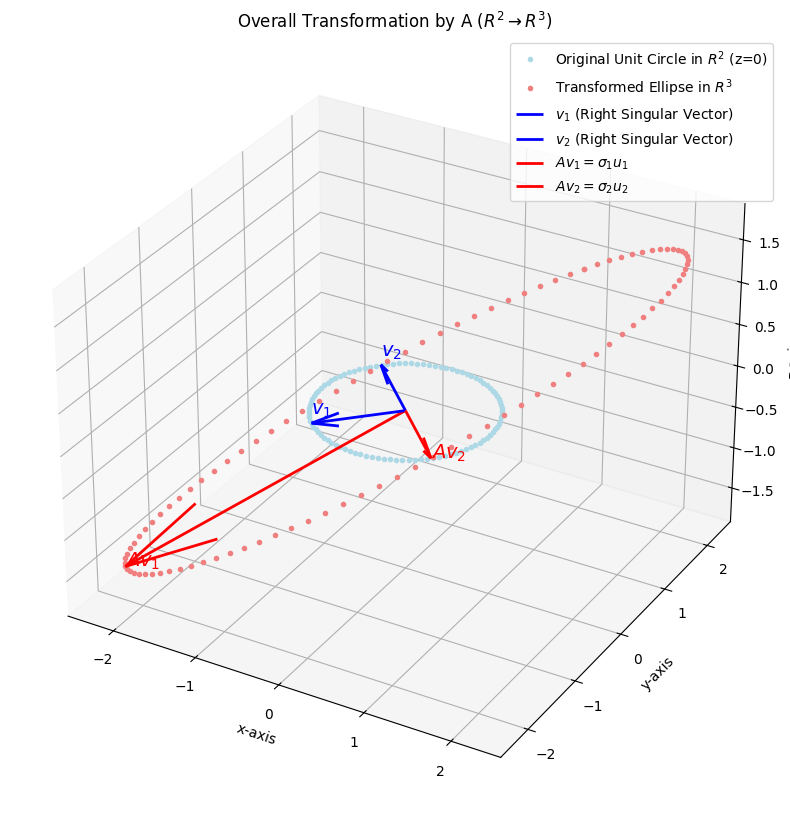

In [165]:
# 시각화를 위한 3D 플롯 준비
from mpl_toolkits.mplot3d import Axes3D

# R²의 단위 원 데이터 생성
t = np.linspace(0, 2 * np.pi, 100)
circle_points_2d = np.vstack([np.cos(t), np.sin(t)])

# 행렬 A에 의한 변환 결과 (R³ 공간의 타원)
transformed_points_3d = A @ circle_points_2d

# R²의 표준 기저 벡터 (e1, e2)
e1_2d = np.array([[1], [0]])
e2_2d = np.array([[0], [1]])

# 기저 벡터의 변환 결과 (Ae1, Ae2)
Ae1_3d = A @ e1_2d
Ae2_3d = A @ e2_2d

# R²의 우측 특이벡터 (v1, v2)
v1 = V[:, 0]
v2 = V[:, 1]

# 우측 특이벡터의 변환 결과 (Av1=σ₁u₁, Av2=σ₂u₂)
Av1_3d = A @ v1
Av2_3d = A @ v2

# 3D 시각화
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 원본 단위 원을 z=0 평면에 플로팅
ax.plot(circle_points_2d[0, :], circle_points_2d[1, :], 0, 'o', c='lightblue', markersize=3, label='Original Unit Circle in $R^2$ (z=0)')

# 변환된 타원을 R³에 플로팅
ax.plot(transformed_points_3d[0, :], transformed_points_3d[1, :], transformed_points_3d[2, :], 'o', c='lightcoral', markersize=3, label='Transformed Ellipse in $R^3$')

# R²의 우측 특이벡터(v1, v2)를 z=0 평면에 화살표로 시각화
ax.quiver(0, 0, 0, v1[0], v1[1], 0, color='blue', linewidth=2, label='$v_1$ (Right Singular Vector)')
ax.quiver(0, 0, 0, v2[0], v2[1], 0, color='blue', linewidth=2, label='$v_2$ (Right Singular Vector)')
ax.text(v1[0], v1[1], 0.1, '$v_1$', color='blue', size=14)
ax.text(v2[0], v2[1], 0.1, '$v_2$', color='blue', size=14)

# 변환된 벡터(Av1, Av2)를 R³에 화살표로 시각화
ax.quiver(0, 0, 0, Av1_3d[0], Av1_3d[1], Av1_3d[2], color='red', linewidth=2, label='$Av_1 = \sigma_1 u_1$')
ax.quiver(0, 0, 0, Av2_3d[0], Av2_3d[1], Av2_3d[2], color='red', linewidth=2, label='$Av_2 = \sigma_2 u_2$')
ax.text(Av1_3d[0], Av1_3d[1], Av1_3d[2], '$Av_1$', color='red', size=14)
ax.text(Av2_3d[0], Av2_3d[1], Av2_3d[2], '$Av_2$', color='red', size=14)

# 플롯 설정
ax.set_title('Overall Transformation by A ($R^2 \\rightarrow R^3$)')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.legend()
ax.axis('equal')
ax.grid(True)
plt.show()

위 그림은 행렬 변환 A가 2차원 공간을 3차원 공간으로 어떻게 변환하는지 보여줍니다.
- 파란색 점(z=0 평면 위의 단위 원)이 행렬 A에 의해 3차원 공간의 빨간색 점(타원)으로 변환됩니다.
- 입력 공간($R^2$)의 서로 직교하는 두 우측 특이벡터($v_1, v_2$)는 변환 후에도 여전히 서로 직교하는 벡터($Av_1, Av_2$)가 됩니다. 이 벡터들은 출력 공간($R^3$)에 있는 타원의 장축과 단축을 형성합니다.
- 변환된 벡터 $Av_1, Av_2$의 길이는 각각 특이값 $\sigma_1, \sigma_2$ 배만큼 조절되며, 방향은 좌측 특이벡터 $u_1, u_2$의 방향과 일치합니다. ($Av_i = \sigma_i u_i$)
- 즉, SVD는 입력 공간의 직교 기저($V$)를 출력 공간의 직교 기저($U$)로 매핑하는 변환으로 이해할 수 있습니다.

## 4. 주성분 분석 (Principal Component Analysis, PCA)

주성분 분석(PCA)은 대표적인 차원 축소(Dimensionality Reduction) 기법입니다. 데이터에 내재된 정보 손실을 최소화하면서 고차원 데이터를 저차원 공간으로 선형 변환하는 방법으로, 데이터의 분산(variance)이 가장 큰 방향을 새로운 좌표축, 즉 주성분(Principal Component)으로 설정합니다.

PCA의 수학적 핵심은 데이터의 공분산 행렬(Covariance Matrix)에 대한 고유값 분해(Eigendecomposition)입니다. 각 특징(열)의 평균을 0으로 중심화한 데이터 행렬 X(샘플 수 x 특징 수)가 주어졌을 때, 공분산 행렬 C는 다음과 같이 계산됩니다.

$$ C = \frac{1}{n-1}X^T X \quad \text{(단, X는 평균이 0으로 중심화된 데이터)}$$

이 공분산 행렬 C를 고유값 분해하면 다음과 같습니다.

$$C = W \Lambda W^T$$

* W: 공분산 행렬 C의 고유벡터(eigenvector)들을 열(column)으로 갖는 직교 행렬(orthogonal matrix)입니다. 이 고유벡터들이 데이터의 분산이 가장 큰 방향을 나타내는 새로운 축, 즉 주성분(Principal Components)이 됩니다.
* Λ: C의 고유값(eigenvalue)들을 대각 원소로 갖는 대각 행렬(diagonal matrix)입니다. 각 고유값은 해당 고유벡터(주성분) 방향으로 데이터가 갖는 분산의 크기를 의미하며, 이 값이 클수록 해당 주성분이 더 많은 정보를 설명함을 뜻합니다.

### 기하학적 의미: 데이터의 새로운 주축 찾기

PCA는 복잡하게 얽혀 있는 데이터를 가장 잘 설명할 수 있는 새로운 좌표계를 찾는 과정으로 해석할 수 있습니다. 주성분은 고유값이 큰 순서대로 정렬되며, 첫 번째 주성분이 데이터의 분산을 가장 많이 설명합니다.

1. 첫 번째 주성분(PC1) 탐색: 데이터를 특정 방향(1차원 직선)으로 정사영(projection)했을 때, 그 분산이 가장 커지는 방향을 찾습니다. 이 방향 벡터가 바로 데이터를 가장 잘 대표하는 첫 번째 주성분(PC1) 축이 됩니다.
2. 두 번째 주성분(PC2) 탐색: 첫 번째 주성분(PC1)에 직교(orthogonal)하는 방향들 중에서, 데이터를 정사영했을 때 분산이 가장 커지는 다음 방향을 찾습니다. 이 방향이 두 번째 주성분(PC2)이 됩니다.
3. 반복 및 좌표계 생성: 이 과정을 반복하면, 데이터의 원래 차원 수만큼 서로 직교하는 주성분 축들을 얻을 수 있습니다. 이 주성분들은 데이터를 설명하는 새로운 좌표계의 기저(basis)를 이룹니다.
4. 차원 축소: 각 주성분은 해당 축 방향의 분산 크기를 나타내는 고유값을 가집니다. 고유값이 큰 상위 k개의 주성분(데이터의 분산을 많이 설명하는 축)만 선택하고, 원본 데이터를 이 k개의 축으로 이루어진 새로운 공간에 정사영하면, 데이터의 정보 손실을 최소화하며 차원을 효과적으로 축소할 수 있습니다.

### 4.1. 데이터 생성 및 중심화
두 변수 간에 강한 상관관계를 갖는 2차원 데이터를 생성합니다. PCA는 분산을 기반으로 하므로, 분석에 앞서 각 변수의 평균을 0으로 맞추는 데이터 중심화(Centering) 전처리를 필수로 수행합니다.

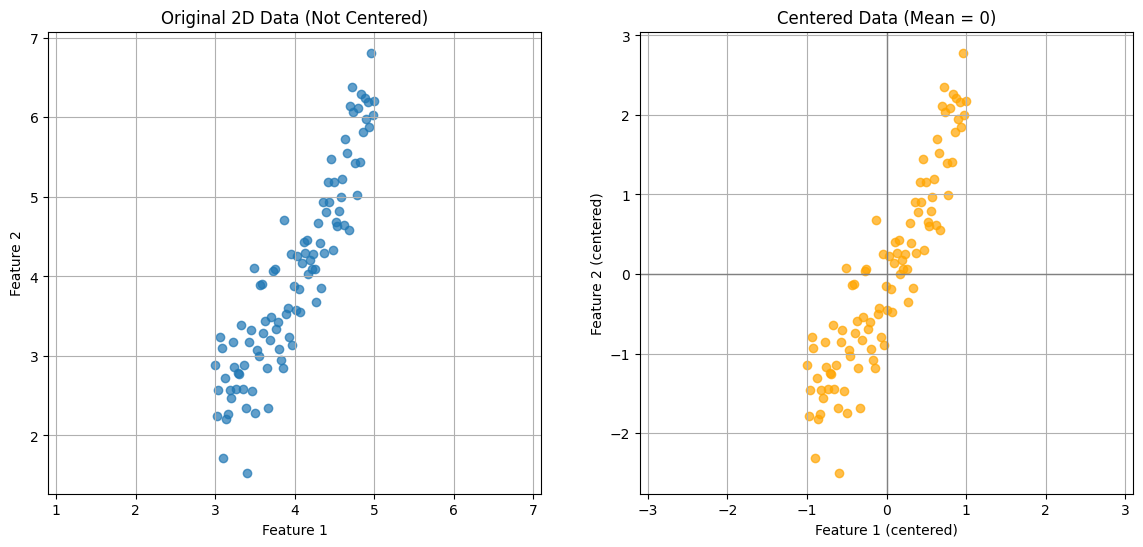

In [166]:
# 2D 예제 데이터 생성
num_samples = 100
x_pca_2d = np.linspace(3, 5, num_samples)
y_pca_2d = 2 * x_pca_2d - 4 + np.random.normal(0, 0.5, num_samples)
data_2d = np.array([x_pca_2d, y_pca_2d]).T

# 데이터 전처리: 평균 중심화 (모든 데이터 포인트에서 평균 벡터를 뺍니다)
mean_vec = np.mean(data_2d, axis=0)
centered_data = data_2d - mean_vec

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.7)
axes[0].set_title("Original 2D Data (Not Centered)")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")
axes[0].axis('equal')
axes[0].grid(True)

axes[1].scatter(centered_data[:, 0], centered_data[:, 1], alpha=0.7, color='orange')
axes[1].set_title("Centered Data (Mean = 0)")
axes[1].set_xlabel("Feature 1 (centered)")
axes[1].set_ylabel("Feature 2 (centered)")
axes[1].axhline(0, color='grey', lw=1)
axes[1].axvline(0, color='grey', lw=1)
axes[1].axis('equal')
axes[1].grid(True)
plt.show()

### 4.2. 주성분 계산 (공분산 행렬의 고유값 분해)
중심화된 데이터의 공분산 행렬을 계산하고, 이를 고유값 분해하여 주성분(고유벡터)과 그 중요도(고유값)를 찾습니다. 고유값이 가장 큰 고유벡터가 제1 주성분(PC1)이 됩니다.

공분산 행렬:
 [[0.34 0.66]
 [0.66 1.53]]

고유값 (분산 크기, 내림차순):
 [1.82 0.05]

제1 주성분 (PC1, 가장 분산이 큰 방향):
 [0.41 0.91]


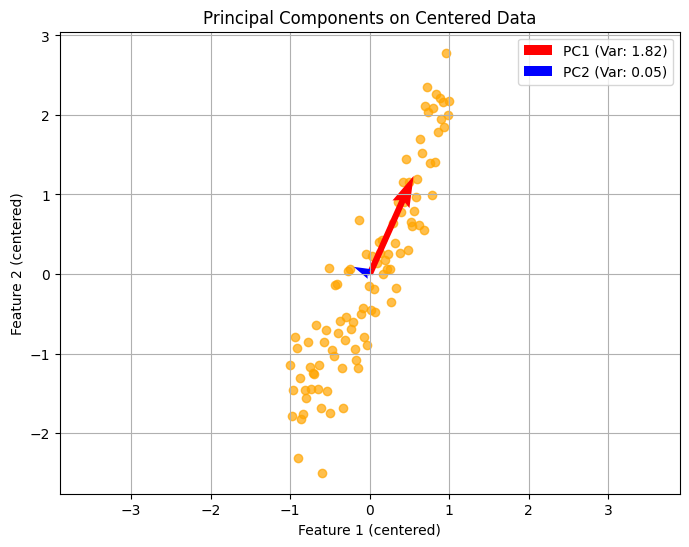

In [167]:
# 공분산 행렬 계산
# np.cov는 (특징 수, 샘플 수) 형태의 입력을 기대하므로, (샘플 수, 특징 수) 형태인 데이터를 전치(.T)합니다.
cov_matrix = np.cov(centered_data.T)

# 공분산 행렬의 고유값 분해
# 대칭행렬이므로 eigh를 사용하면 더 효율적이고 안정적입니다.
eigenvalues_pca, eigenvectors_pca = np.linalg.eigh(cov_matrix)

# 고유값이 큰 순서대로 고유값과 고유벡터를 정렬합니다.
sort_indices = np.argsort(eigenvalues_pca)[::-1]
eigenvalues_pca = eigenvalues_pca[sort_indices]
eigenvectors_pca = eigenvectors_pca[:, sort_indices]

# 제1 주성분(PC1)은 가장 큰 고유값에 해당하는 고유벡터입니다.
pc1 = eigenvectors_pca[:, 0]
pc2 = eigenvectors_pca[:, 1]


print("공분산 행렬:\n", np.round(cov_matrix, 2))
print("\n고유값 (분산 크기, 내림차순):\n", np.round(eigenvalues_pca, 2))
print("\n제1 주성분 (PC1, 가장 분산이 큰 방향):\n", np.round(pc1, 2))

# 주성분 시각화
plt.figure(figsize=(8, 6))
plt.scatter(centered_data[:, 0], centered_data[:, 1], alpha=0.7, color='orange')
# 화살표(quiver)로 주성분 방향을 표시합니다. 화살표 길이는 분산의 크기(고유값의 제곱근)를 반영합니다.
plt.quiver(0, 0, pc1[0] * np.sqrt(eigenvalues_pca[0]), pc1[1] * np.sqrt(eigenvalues_pca[0]),
           color='red', scale_units='xy', scale=1, width=0.01, label=f'PC1 (Var: {eigenvalues_pca[0]:.2f})')
plt.quiver(0, 0, pc2[0] * np.sqrt(eigenvalues_pca[1]), pc2[1] * np.sqrt(eigenvalues_pca[1]),
           color='blue', scale_units='xy', scale=1, width=0.01, label=f'PC2 (Var: {eigenvalues_pca[1]:.2f})')
plt.title("Principal Components on Centered Data")
plt.xlabel("Feature 1 (centered)")
plt.ylabel("Feature 2 (centered)")
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

### 4.3. 차원 축소 및 데이터 재구성
2차원 데이터를 PC1 축 하나로 사영(projection)하여 1차원으로 축소하고, 다시 2차원으로 복원해봅니다. 이 과정은 PCA가 정보 손실을 감수하고 데이터의 가장 중요한 특징으로 원본을 근사하는 과정을 명확히 보여줍니다. 재구성된 데이터는 PC1 직선 위에 위치하게 됩니다.

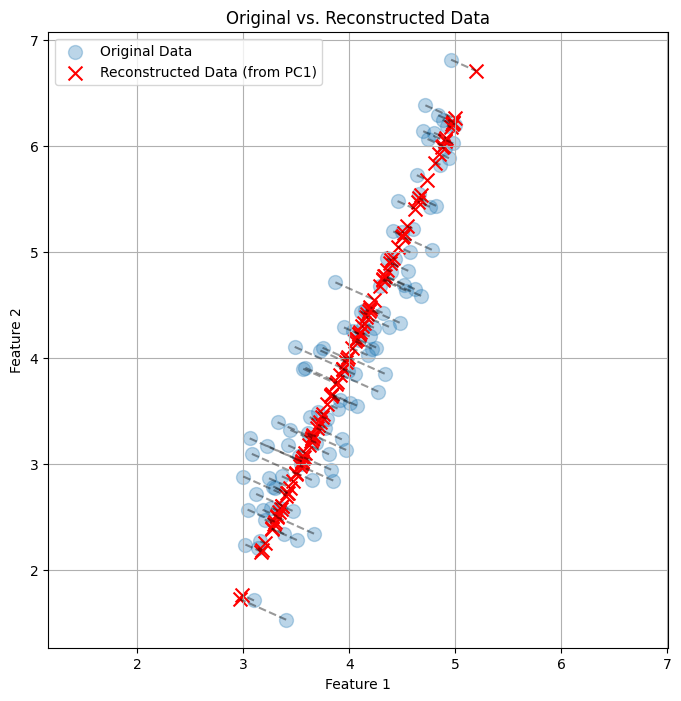

In [168]:
# 차원 축소: 중심화된 데이터를 PC1 벡터에 사영하여 2D -> 1D로 변환
projected_data_1d = centered_data @ pc1

# 데이터 재구성: 1D 데이터를 다시 2D 공간으로 복원
# (사영된 1D 데이터)와 (PC1 벡터)의 외적(outer product)을 이용합니다.
reconstructed_centered_data = projected_data_1d[:, np.newaxis] @ pc1[np.newaxis, :]
# 원본 데이터 공간으로 이동 (데이터 중심화 시 뺐던 평균을 다시 더해줌)
reconstructed_data = reconstructed_centered_data + mean_vec


# 시각화
plt.figure(figsize=(8, 8))
# 원본 데이터와 재구성된 데이터 플로팅
plt.scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.3, s=100, label='Original Data')
plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], color='red', marker='x', s=100, label='Reconstructed Data (from PC1)')
# 원본과 재구성된 데이터 간의 오차를 점선으로 연결
for i in range(len(data_2d)):
    plt.plot([data_2d[i, 0], reconstructed_data[i, 0]], [data_2d[i, 1], reconstructed_data[i, 1]], 'k--', alpha=0.4)

plt.title("Original vs. Reconstructed Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

### 4.4. MNIST 데이터 준비 및 분산 설명량 확인
784차원의 고차원 MNIST 이미지 데이터에 PCA를 적용합니다. 각 주성분이 전체 데이터 분산의 몇 %를 설명하는지 시각화하여, 몇 개의 주성분이 데이터의 정보를 효과적으로 압축하는지 확인합니다.

* 스크리 도표(Scree Plot): 각 주성분(고유값)의 상대적 중요도를 시각적으로 보여줍니다.
* 누적 분산 설명량 그래프: k개의 주성분을 사용했을 때, 원본 분산의 몇 %를 보존할 수 있는지 보여줍니다.

선택된 숫자: [0, 1, 8], 데이터 크기: (21605, 784)


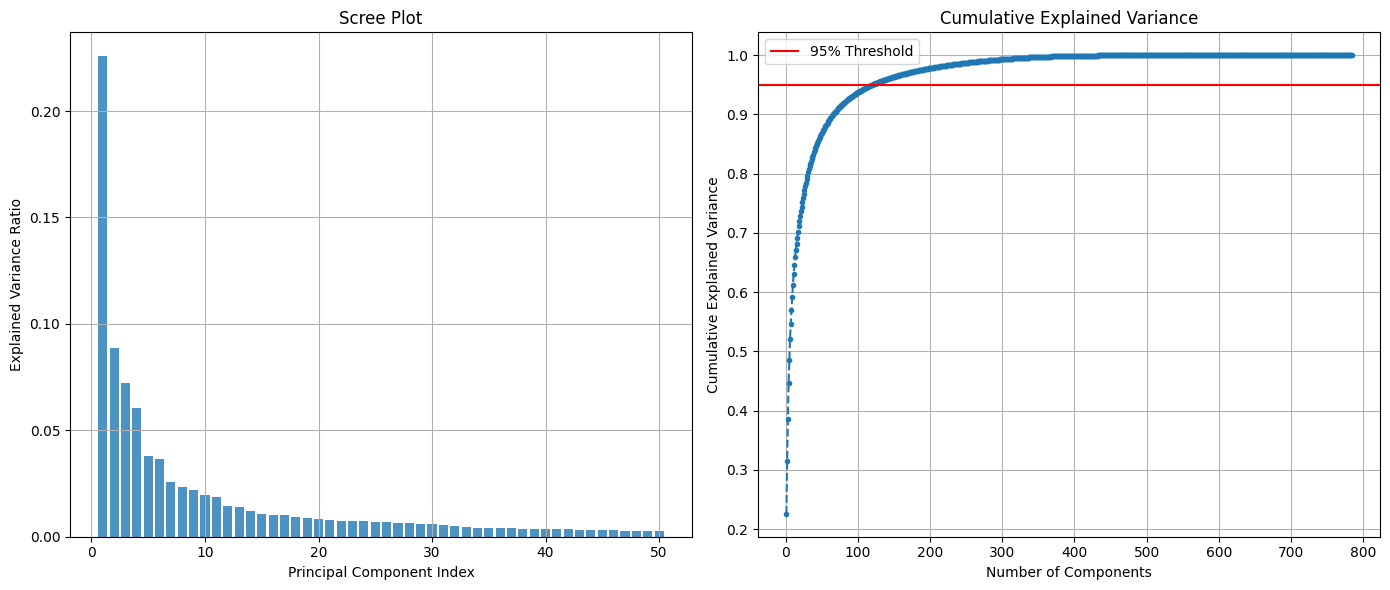

데이터 분산의 95%를 설명하는 데 필요한 주성분 개수: 120


In [169]:
# 실습: 분석하고 싶은 숫자들을 리스트에 포함시켜 보세요. 예: [3, 8], [0, 1, 7], list(range(10))
selected_digits = [0, 1, 8]

# 선택된 숫자에 해당하는 데이터만 필터링
if X_mnist_data is not None:
    filter_mask = np.isin(y_mnist_data, selected_digits)
    X_mnist = X_mnist_data[filter_mask]
    y_mnist = y_mnist_data[filter_mask]
    print(f"선택된 숫자: {selected_digits}, 데이터 크기: {X_mnist.shape}")

    # 데이터 중심화
    X_centered_mnist = X_mnist - np.mean(X_mnist, axis=0)

    # 공분산 행렬 계산 및 고유값 분해
    cov_matrix_mnist = np.cov(X_centered_mnist.T)
    eigenvalues_mnist, eigenvectors_mnist = np.linalg.eigh(cov_matrix_mnist)
    sort_indices_mnist = np.argsort(eigenvalues_mnist)[::-1]
    eigenvalues_mnist = eigenvalues_mnist[sort_indices_mnist]
    eigenvectors_mnist = eigenvectors_mnist[:, sort_indices_mnist]

    # 분산 설명량 계산
    explained_variance_ratio = eigenvalues_mnist / np.sum(eigenvalues_mnist)
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    # 시각화
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    num_components_to_plot = min(50, X_centered_mnist.shape[1])
    plt.bar(range(1, num_components_to_plot + 1), explained_variance_ratio[:num_components_to_plot], alpha=0.8)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component Index')
    plt.ylabel('Explained Variance Ratio')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='.', linestyle='--')
    plt.axhline(y=0.95, color='r', linestyle='-', label='95% Threshold')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # 데이터 분산의 95%를 설명하기 위해 필요한 주성분의 개수를 찾습니다.
    n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
    print(f"데이터 분산의 95%를 설명하는 데 필요한 주성분 개수: {n_components_95}")
else:
    print("MNIST 데이터가 로드되지 않아 이 실습을 건너뜁니다.")

### 4.5. 저차원 시각화 및 이미지 재구성
784차원의 이미지 데이터를 가장 중요한 두 개의 주성분(PC1, PC2)만 사용하여 2차원으로 축소하고, 그 결과를 산점도로 시각화하여 데이터의 분포를 확인합니다. 또한, 사용하는 주성분의 개수(k)를 늘려가며 원본 이미지를 재구성하여, 적은 수의 주성분만으로도 원본 이미지의 핵심 특징이 복원되는 것을 관찰합니다.

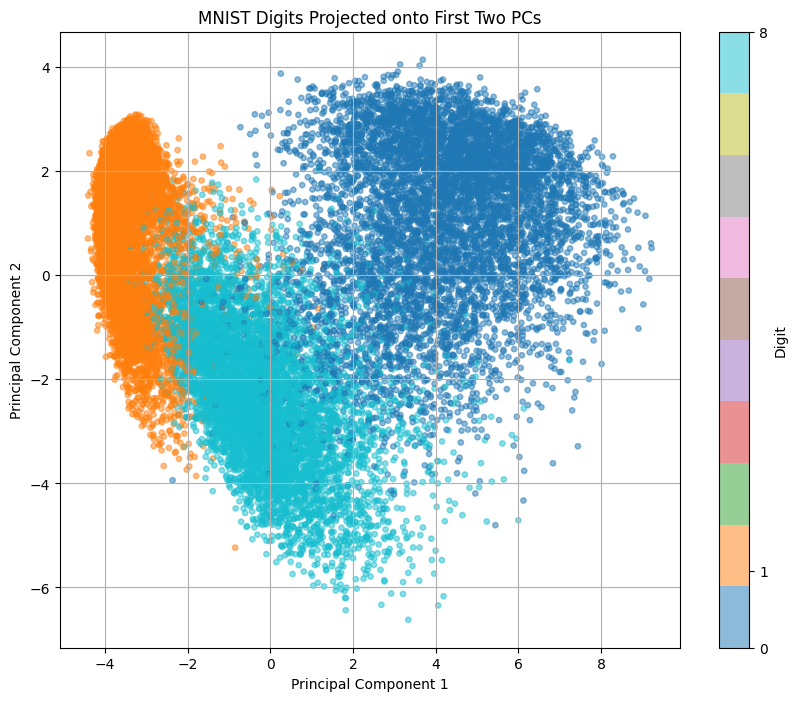

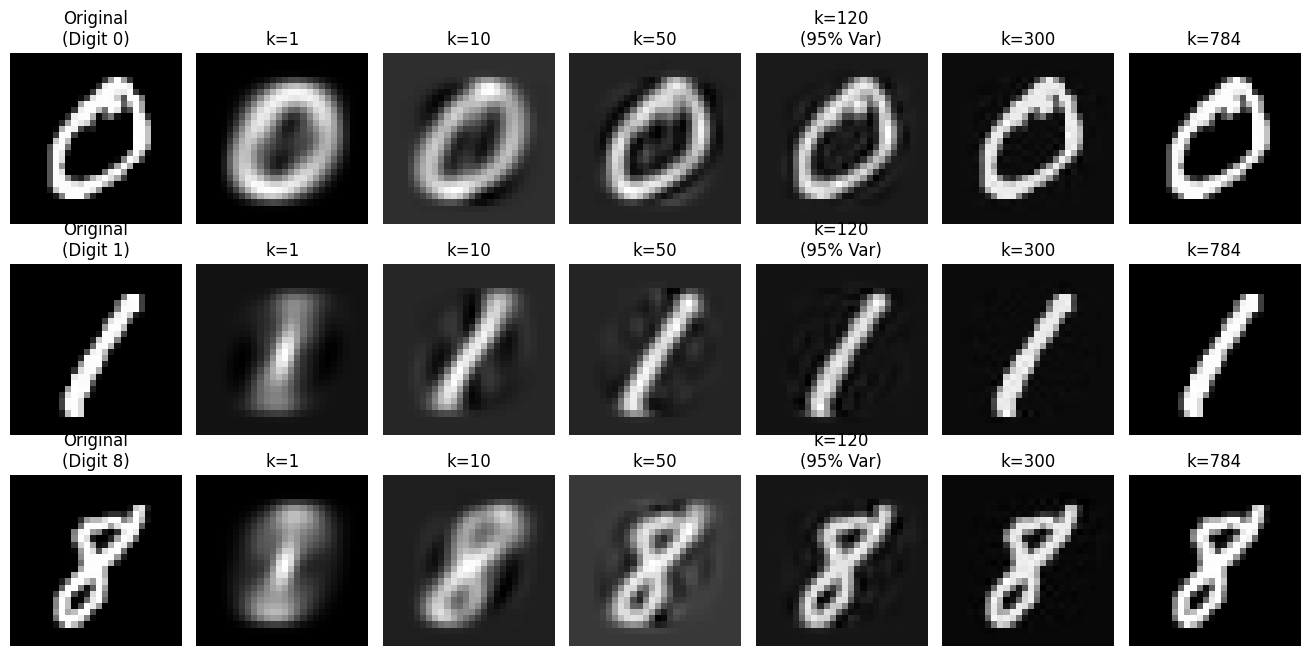

In [170]:
if X_mnist_data is not None:
    # 2차원으로 사영 및 시각화
    # 가장 중요한 두 주성분(PC1, PC2)을 선택합니다.
    pc1_mnist = eigenvectors_mnist[:, 0]
    pc2_mnist = eigenvectors_mnist[:, 1]
    # 중심화된 데이터를 PC1, PC2에 사영합니다.
    projected_mnist = np.c_[X_centered_mnist @ pc1_mnist, X_centered_mnist @ pc2_mnist]

    plt.figure(figsize=(10, 8))
    # 2차원 공간에 사영된 데이터를 숫자 레이블에 따라 다른 색으로 표시합니다.
    scatter = plt.scatter(projected_mnist[:, 0], projected_mnist[:, 1], c=y_mnist, cmap=plt.get_cmap("tab10", 10), alpha=0.5, s=15)
    plt.title("MNIST Digits Projected onto First Two PCs")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    cbar = plt.colorbar(scatter, ticks=np.unique(y_mnist))
    cbar.set_label('Digit')
    plt.grid(True)
    plt.show()

    # k개의 주성분을 사용하여 이미지 재구성
    def reconstruct_image(centered_data, eigenvectors, k, img_idx):
        """주어진 k개의 주성분으로 원본 데이터를 재구성하는 함수"""
        # 상위 k개의 주성분을 선택합니다.
        top_k_pcs = eigenvectors[:, :k]
        # 데이터를 k차원으로 사영합니다.
        projected_data = centered_data[img_idx] @ top_k_pcs
        # k차원 데이터를 다시 원본 784차원으로 재구성합니다.
        reconstructed_data = projected_data @ top_k_pcs.T
        return reconstructed_data

    # 각 숫자 클래스에서 첫 번째 샘플을 선택합니다.
    sample_indices = [np.where(y_mnist == digit)[0][0] for digit in selected_digits if np.any(y_mnist == digit)]

    # 실습: 이미지를 재구성할 때 사용할 주성분 개수(k)를 바꿔보세요.
    k_values = [1, 10, 50, n_components_95, 300, 784]
    num_k = len(k_values)
    num_samples_to_show = len(sample_indices)

    fig, axes = plt.subplots(num_samples_to_show, num_k + 1, figsize=(num_k * 2.2, num_samples_to_show * 2.2))
    if num_samples_to_show == 1: axes = axes.reshape(1, -1)
    
    mean_image = np.mean(X_mnist, axis=0)

    for i, img_idx in enumerate(sample_indices):
        # 첫 번째 열: 원본 이미지
        axes[i, 0].imshow(X_mnist[img_idx].reshape(28, 28), cmap='gray')
        axes[i, 0].set_title(f"Original\n(Digit {y_mnist[img_idx]})")
        axes[i, 0].axis('off')

        # 이후 열: k개의 주성분으로 재구성된 이미지
        for j, k in enumerate(k_values):
            # k가 데이터의 최대 차원보다 클 수 없으므로 예외 처리
            if k > X_centered_mnist.shape[1]:
                axes[i, j + 1].set_title(f"k > {X_centered_mnist.shape[1]}")
                axes[i, j + 1].axis('off')
                continue
            
            # 이미지 재구성
            reconstructed_centered = reconstruct_image(X_centered_mnist, eigenvectors_mnist, k, img_idx)
            # 중심화된 데이터를 재구성했으므로, 다시 원본 스케일로 돌리기 위해 평균을 더해줍니다.
            reconstructed_img = reconstructed_centered + mean_image
            axes[i, j + 1].imshow(reconstructed_img.reshape(28, 28), cmap='gray')
            title = f"k={k}"
            if k == n_components_95:
                title += "\n(95% Var)"
            axes[i, j + 1].set_title(title)
            axes[i, j + 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("MNIST 데이터가 로드되지 않아 이 실습을 건너뜁니다.")